# Chapter 1 - Setup & Data formatting

In [179]:
import yfinance as yf

TICKER = "SPY"
df = yf.download(TICKER, start="2015-01-01", progress=False).dropna()
df.columns = [("_".join(c) if isinstance(c, tuple) else c).lower().replace(" ", "_") for c in df.columns]
df.columns

/var/folders/hd/tdkj0lzs7zb05pcnc54nqzv80000gn/T/ipykernel_10573/2738435976.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start="2015-01-01", progress=False).dropna()


Index(['close_spy', 'high_spy', 'low_spy', 'open_spy', 'volume_spy'], dtype='object')

In [180]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

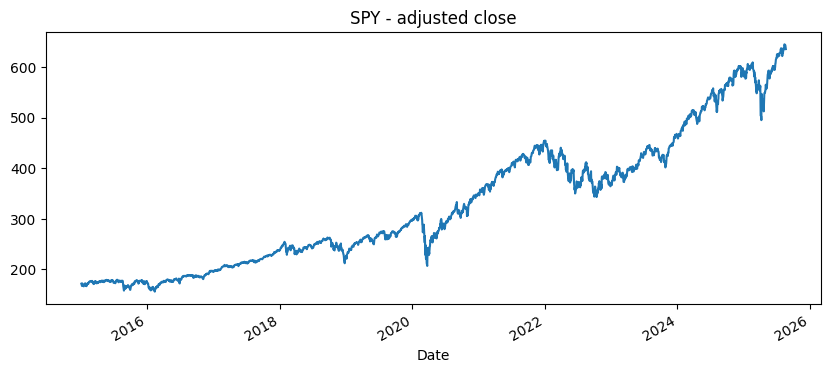

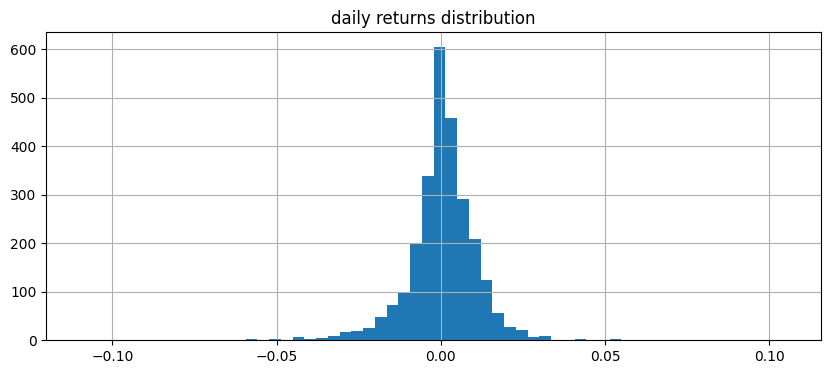

,close_spy,volume_spy
Date,,
2025-08-15,643.440002,68592500
2025-08-18,643.299988,43804900
2025-08-19,639.809998,69750700
2025-08-20,638.109985,88890300
2025-08-21,635.549988,49418682


In [181]:
close_var = "close_" + TICKER.lower()

df[close_var].plot(title=f"{TICKER} - adjusted close"); plt.show()

df["ret_1d"] = df[close_var].pct_change()
df["ret_1d"].hist(bins=60)
plt.title("daily returns distribution"); plt.show()

df[[close_var, "volume_" + TICKER.lower()]].tail()

In [182]:
tickerlow = "_" + TICKER.lower()
assert df.index.is_monotonic_increasing
assert {"open" + tickerlow, "high" + tickerlow, "low" + tickerlow, "close" + tickerlow, "volume" + tickerlow}.issubset(df.columns)
df.isna().sum()

close_spy     0
high_spy      0
low_spy       0
open_spy      0
volume_spy    0
ret_1d        1
dtype: int64

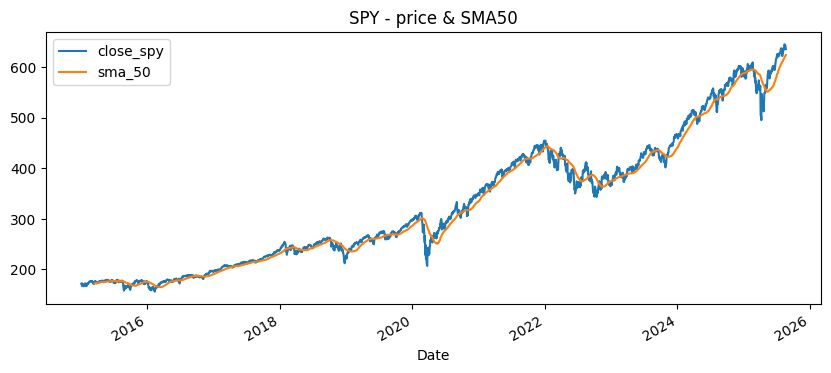

In [183]:
df["sma_50"] = df[close_var].rolling(50).mean()
df[[close_var, "sma_50"]].plot(title=f"{TICKER} - price & SMA50"); plt.show()

# Chapter 2 - Indicators & Target

In [184]:
def rsi(series, n=14):
    delta = series.diff()
    up = np.where(delta>0, delta, 0.0)
    down = np.where(delta<0, -delta, 0.0)
    roll_up = pd.Series(up, index=series.index).rolling(n).mean()
    roll_down = pd.Series(down, index = series.index).rolling(n).mean()
    rs = roll_up / (roll_down + 1e-8)
    return 100 - (100 / (1 + rs))

In [185]:
close = df[close_var]

for w in (5, 10, 20):
    df[f"sma_{w}"] = close.rolling(w).mean()
    df[f"mom_{w}"] = close.pct_change(w)
    df[f"vol_{w}"] = df["ret_1d"].rolling(w).std()
df["rsi_14"] = rsi(close, 14)

df["target_reg"] = df["ret_1d"].shift(-1)
df["target_cls"] = (df["target_reg"] > 0).astype(int)

df = df.dropna()
df.tail()


,close_spy,high_spy,low_spy,open_spy,volume_spy,ret_1d,sma_50,sma_5,mom_5,vol_5,sma_10,mom_10,vol_10,sma_20,mom_20,vol_20,rsi_14,target_reg,target_cls
Date,,,,,,,,,,,,,,,,,,,
2025-08-14,644.950012,645.619995,642.340027,642.789978,59327500,0.000093,619.650876,641.126001,0.020087,0.005242,635.151996,0.020361,0.009021,634.060001,0.026925,0.006709,58.077807,-0.002341,0
2025-08-15,643.440002,646.090027,642.520020,645.989990,68592500,-0.002341,620.636207,642.378003,0.009825,0.005364,637.323999,0.034935,0.006597,634.853000,0.025272,0.006745,56.507785,-0.000218,0
2025-08-18,643.299988,644.000000,642.179993,642.859985,43804900,-0.000218,621.676168,643.854004,0.011605,0.005091,638.537000,0.019218,0.005203,635.579498,0.023109,0.006751,58.305727,-0.005425,0
2025-08-19,639.809998,644.109985,638.479980,643.119995,69750700,-0.005425,622.524888,643.278003,-0.004481,0.003267,639.721002,0.018854,0.005257,636.126999,0.017412,0.006908,55.235813,-0.002657,0
2025-08-20,638.109985,639.659973,632.950012,639.400024,88890300,-0.002657,623.328839,641.921997,-0.010513,0.002224,640.253998,0.008423,0.005003,636.321997,0.006149,0.006708,55.980899,-0.004012,0


In [186]:
feature_cols = [c for c in df.columns if c not in ("target_reg","target_cls")]
len(feature_cols), feature_cols[:8]

(17,
 ['close_spy',
  'high_spy',
  'low_spy',
  'open_spy',
  'volume_spy',
  'ret_1d',
  'sma_50',
  'sma_5'])

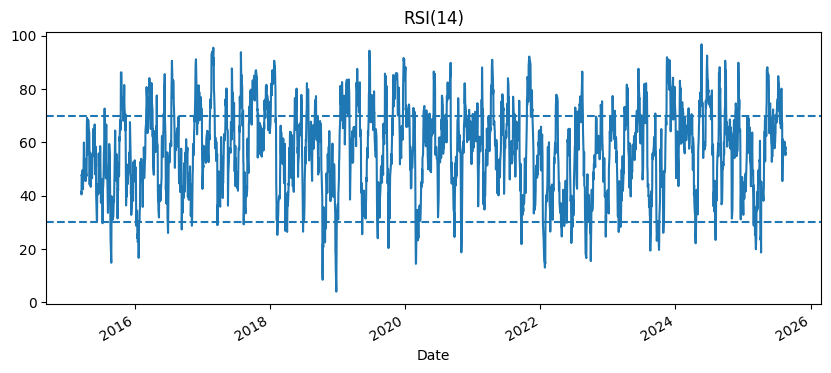

In [187]:
df["rsi_14"].plot(title="RSI(14)"); plt.axhline(70, ls="--"); plt.axhline(30, ls="--"); plt.show()

# Chapter 3 - Time-aware train/val/test split

In [188]:
import pandas as pd

TRAIN_END = pd.Timestamp("2021-12-31")
VAL_END = pd.Timestamp("2023-12-31")

train_df = df.loc[:TRAIN_END].copy()
val_df = df.loc[TRAIN_END + pd.Timedelta(days=1) : VAL_END].copy()
test_df = df.loc[VAL_END + pd.Timedelta(days=1):].copy()

len(train_df), len(val_df), len(test_df)

(1714, 501, 410)

In [189]:
assert df.index.is_monotonic_increasing, "index must be time-ordered"
assert train_df.index.max() <= val_df.index.min() <= val_df.index.max() <= test_df.index.min() or len(test_df) == 0, "dataframes must be contiguous and non-overlapping"

print(f"Train: {train_df.index.min().date()} -> {train_df.index.max().date()} | rows: {len(train_df)}")
print(f"Val: {val_df.index.min().date()} -> {val_df.index.max().date()} | rows: {len(val_df)}")
print(f"Test: {test_df.index.min().date()} -> {test_df.index.max().date()} | rows: {len(test_df)}")

Train: 2015-03-16 -> 2021-12-31 | rows: 1714
Val: 2022-01-03 -> 2023-12-29 | rows: 501
Test: 2024-01-02 -> 2025-08-20 | rows: 410


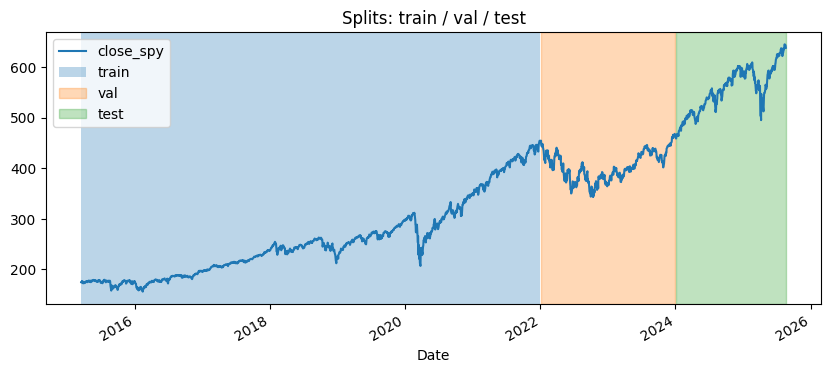

In [190]:
import matplotlib.pyplot as plt
ax = df[close_var].plot(figsize=(10,4), title="Splits: train / val / test")
plt.axvspan(train_df.index.min(), train_df.index.max(), alpha=0.3, label="train")
plt.axvspan(val_df.index.min(),   val_df.index.max(),   alpha=0.3, label="val", color="tab:orange")
plt.axvspan(test_df.index.min(),  test_df.index.max(),  alpha=0.3, label="test", color="tab:green")
plt.legend(); plt.show()

In [191]:
def make_xy(dfx, feat_cols, target_col="target_reg", lookback=30):
    X, y = [], []
    vals = dfx[feat_cols].values
    t    = dfx[target_col].values
    for i in range(lookback, len(dfx)):
        X.append(vals[i-lookback:i])
        y.append(t[i])
    return np.array(X), np.array(y)

In [192]:
feature_cols = [c for c in df.columns if c not in ("target_reg", "target_cls")]

lookback = 30

X_tr, y_tr = make_xy(train_df, feature_cols, lookback=lookback)
X_va, y_va = make_xy(val_df, feature_cols, lookback=lookback)
X_te, y_te = make_xy(test_df, feature_cols, lookback=lookback)


In [193]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_3d(trainX, valX, testX):
    """
    Standardize features (zero mean, unit variance) using train statistics only.
    Keeps 3D shape: (samples, lookback, features).
    """
    # get shapes
    n, L, f = trainX.shape
    
    # STEP 1: flatten trainX into (n*L, f) for scaler
    flat_train = trainX.reshape(-1, f)

    # STEP 2: fit scaler on this flattened array
    scaler = StandardScaler().fit(flat_train)

    # STEP 3: define a helper that flattens any 3D -> transform -> reshape back
    def transform_3d(X):
        n, L, f = X.shape
        flat = X.reshape(n * L, f)
        scaled = scaler.transform(flat)
        return scaled.reshape(n, L, f)

    # STEP 4: apply to trainX, valX, testX
    trainX = transform_3d(trainX)
    valX = transform_3d(valX)
    testX = transform_3d(testX)

    # STEP 5: return scaled versions + the scaler
    return trainX, valX, testX, scaler

X_tr_scaled, X_va_scaled, X_te_scaled, scaler = scale_3d(X_tr, X_va, X_te)
print(X_tr_scaled.shape, X_va_scaled.shape, X_te_scaled.shape)

(1684, 30, 17) (471, 30, 17) (380, 30, 17)


In [194]:
X_tr_s, X_va_s, X_te_s, scaler = scale_3d(X_tr, X_va, X_te)
print(X_tr_s.shape, X_va_s.shape, X_te_s.shape)
print("Mean:", round(X_tr_s.mean(), 4), "Std:", round(X_tr_s.std(), 4))

(1684, 30, 17) (471, 30, 17) (380, 30, 17)
Mean: 0.0 Std: 1.0


# Chapter 4 - Baseline 1

In [195]:
import numpy as np

def persistence_baseline(y_true):
    """
    Baseline: predict tomorrow's return = today's return
    Input: y_true = array of actual returns (1D)
    Output: y_pred = array of predictions (aligned with y_true)
    """

    # STEP 1: shift y_true by 1 day to make predictions
    y_pred = y_true[:-1]
    y_true = y_true[1:]

    # STEP 2: calculate MAE = mean(|y_true - y_pred|)
    mae = np.mean(np.abs(y_true - y_pred))

    # STEP 3: calculate directional accuracy
    da = np.mean(np.sign(y_true) == np.sign(y_pred))

    # STEP 4: return y_pred, MAE, DA
    return y_pred, mae, da

In [196]:
import numpy as np
from sklearn.linear_model import Ridge  # or LinearRegression
from sklearn.metrics import mean_absolute_error

# 4.2.a — flatten windows: (N, L, F) -> (N, L*F)
def flatten_windows(X):
    """
    X: 3D array (samples, lookback, features)
    return: 2D array (samples, lookback*features)
    """
    # STEP 1: get shape
    n, L, f = X.shape
    # STEP 2: reshape and return
    return X.reshape(n, L * f)


# 4.2.b — train a ridge regression on TRAIN only
def train_ridge_reg(X_tr_s, y_tr, alpha=1.0):
    """
    Fit Ridge regression on flattened train windows.
    """
    # STEP 1: flatten X_tr_s
    X_tr_flat = flatten_windows(X_tr_s)
    # STEP 2: init model = Ridge(alpha=alpha, fit_intercept=True, random_state=0)
    model = Ridge(alpha=alpha, fit_intercept=True, random_state=0)
    # STEP 3: fit on (X_tr_flat, y_tr)
    # STEP 4: return fitted model
    return model.fit(X_tr_flat, y_tr) 


# 4.2.c — predict + evaluate (MAE, Directional Accuracy)
def eval_linreg(model, X_s, y_true):
    """
    Predict y for given split and compute metrics.
    Returns y_pred, MAE, DA
    """
    # STEP 1: flatten X_s
    X_s_flat = flatten_windows(X_s)
    # STEP 2: y_pred = model.predict(X_flat)
    y_pred = model.predict(X_s_flat)
    # STEP 3: mae = mean_absolute_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # STEP 4: da  = (np.sign(y_true) == np.sign(y_pred)).mean()
    da = (np.sign(y_true) == np.sign(y_pred)).mean()
    # STEP 5: return y_pred, mae, da
    return y_pred, mae, da

In [197]:
# flatten + train
linreg = train_ridge_reg(X_tr_s, y_tr, alpha=1.0)

# validate
yva_pred, va_mae, va_da = eval_linreg(linreg, X_va_s, y_va)
print("VAL  | MAE:", round(va_mae, 6), "DA:", round(va_da, 3))

# test
yte_pred, te_mae, te_da = eval_linreg(linreg, X_te_s, y_te)
print("TEST | MAE:", round(te_mae, 6), "DA:", round(te_da, 3))

VAL  | MAE: 0.00981 DA: 0.546
TEST | MAE: 0.00869 DA: 0.503


In [198]:
ypred_pers, mae_pers, da_pers = persistence_baseline(y_te)
print("Persistence baseline (TEST)")
print("MAE:", round(mae_pers, 6))
print("DA:", round(da_pers, 3))

Persistence baseline (TEST)
MAE: 0.010533
DA: 0.512


In [199]:
import numpy as np
import matplotlib.pyplot as plt

def trading_strategy(y_true, y_pred):
    """
    Simple long/flat trading strategy.
    y_true: actual returns (1D)
    y_pred: predicted returns (1D)
    """
    # STEP 1: get signals: long (1) if y_pred>0 else 0
    signals = (y_pred > 0).astype(int)
    # STEP 2: daily strategy returns = signal * y_true
    strat_returns = signals * y_true
    # STEP 3: cumulative returns = np.cumsum(strategy_returns)
    cum_strat_returns = np.cumsum(strat_returns)
    # STEP 4: buy-and-hold cumulative = np.cumsum(y_true)
    cum_bh_returns = np.cumsum(y_true)
    # STEP 5: return both
    return cum_strat_returns, cum_bh_returns

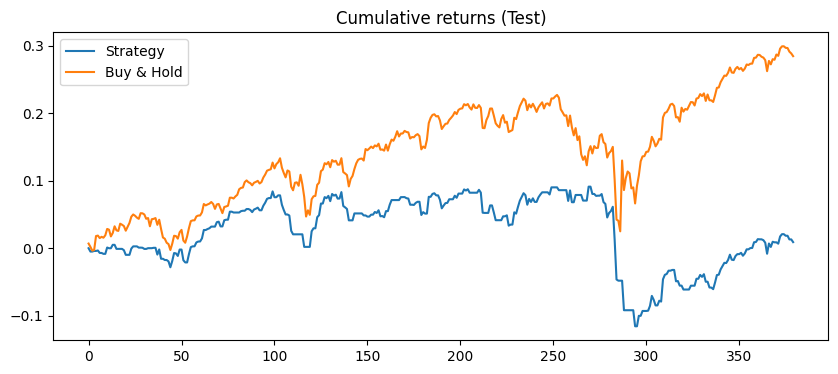

In [200]:
# signals from Ridge on test
_, _, _ = eval_linreg(linreg, X_te_s, y_te)   # you already have yte_pred

strat_cum, bh_cum = trading_strategy(y_te, yte_pred)

plt.plot(strat_cum, label="Strategy")
plt.plot(bh_cum, label="Buy & Hold")
plt.legend()
plt.title("Cumulative returns (Test)")
plt.show()

# Chapter 5 - Define LSTM Model

In [201]:
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=50, num_layers=1, dropout=0.0):
        super().__init__()
        # STEP 1: define LSTM layer
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first=True, # so shape is (batch, seq, features)
            dropout = dropout if num_layers > 1 else 0.0
        )
        # STEP 2: define dropout (optional)
        self.dropout = nn.Dropout(dropout)
        # STEP 3: define a final linear layer mapping hidden_size -> 1
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch, seq, features)
        out, _ = self.lstm(x)

        # STEP 4: pass through LSTM -> get outputs + hidden states
        last = out[:, -1, :]
        # STEP 5: (optional) apply dropout
        last = self.dropout(last)
        # STEP 6: pass last hidden state into linear layer to get prediction
        pred = self.fc(last).squeeze(-1)

        return pred

In [202]:
n_features = X_tr_s.shape[-1]
model = LSTMRegressor(n_features=n_features, hidden_size=64, num_layers=1, dropout=0.1)

import torch
xb = torch.tensor(X_tr_s[:32], dtype=torch.float32)  # a mini-batch
with torch.no_grad():
    yp = model(xb)
yp.shape  # expect: torch.Size([32])

torch.Size([32])

In [203]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def make_loader(X, y, batch_size=64, shuffle=False):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def train_model_stable(model, X_tr, y_tr, X_va, y_va,
                       lr=1e-4, batch_size=64, max_epochs=40, patience=6, device=None,
                       verbose=False):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = make_loader(X_tr, y_tr, batch_size, shuffle=True)
    val_loader   = make_loader(X_va, y_va, batch_size, shuffle=False)

    # More robust loss for noisy returns
    loss_fn = torch.nn.L1Loss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val = float('inf')
    best_state = None
    patience_ctr = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for bi, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)

            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)

            # quick NaN guard
            if not torch.isfinite(loss):
                print(f"[Epoch {epoch} Batch {bi}] Non-finite loss: {loss.item()}")
                return model, best_val  # bail early

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            if verbose and (bi % 50 == 0):
                print(f"[Epoch {epoch} Batch {bi}] train_L1={loss.item():.6f}")

        # ---- validation ----
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                vloss = loss_fn(pred, yb)
                if not torch.isfinite(vloss):
                    print(f"[Epoch {epoch}] Non-finite val loss.")
                    return model, best_val
                val_losses.append(vloss.item())
        val_loss = float(np.mean(val_losses))
        print(f"Epoch {epoch:02d} | val_L1={val_loss:.6f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.to("cpu")
    return model, best_val

In [204]:
n_features = X_tr_s.shape[-1]
model = LSTMRegressor(n_features=n_features, hidden_size=64, num_layers=1, dropout=0.1)
model, best_val = train_model_stable(model, X_tr_s, y_tr, X_va_s, y_va,
                                     lr=1e-4, batch_size=64, max_epochs=40, patience=6)
print("Best val L1:", best_val)

Epoch 01 | val_L1=0.019718
Epoch 02 | val_L1=0.018478
Epoch 03 | val_L1=0.017322
Epoch 04 | val_L1=0.016314
Epoch 05 | val_L1=0.015037
Epoch 06 | val_L1=0.014189
Epoch 07 | val_L1=0.013627
Epoch 08 | val_L1=0.012113
Epoch 09 | val_L1=0.012149
Epoch 10 | val_L1=0.012526
Epoch 11 | val_L1=0.013958
Epoch 12 | val_L1=0.011159
Epoch 13 | val_L1=0.011140
Epoch 14 | val_L1=0.010765
Epoch 15 | val_L1=0.011268
Epoch 16 | val_L1=0.013205
Epoch 17 | val_L1=0.013437
Epoch 18 | val_L1=0.010604
Epoch 19 | val_L1=0.012143
Epoch 20 | val_L1=0.011022
Epoch 21 | val_L1=0.010454
Epoch 22 | val_L1=0.010490
Epoch 23 | val_L1=0.010748
Epoch 24 | val_L1=0.010325
Epoch 25 | val_L1=0.010077
Epoch 26 | val_L1=0.010831
Epoch 27 | val_L1=0.010080
Epoch 28 | val_L1=0.010149
Epoch 29 | val_L1=0.010400
Epoch 30 | val_L1=0.009953
Epoch 31 | val_L1=0.010252
Epoch 32 | val_L1=0.010243
Epoch 33 | val_L1=0.010233
Epoch 34 | val_L1=0.009645
Epoch 35 | val_L1=0.009882
Epoch 36 | val_L1=0.010317
Epoch 37 | val_L1=0.009765
E

Validation MAE: 0.009976644216865123
Validation DA: 0.4734607218683652
Test MAE: 0.014132025586729765
Test DA: 0.4342105263157895


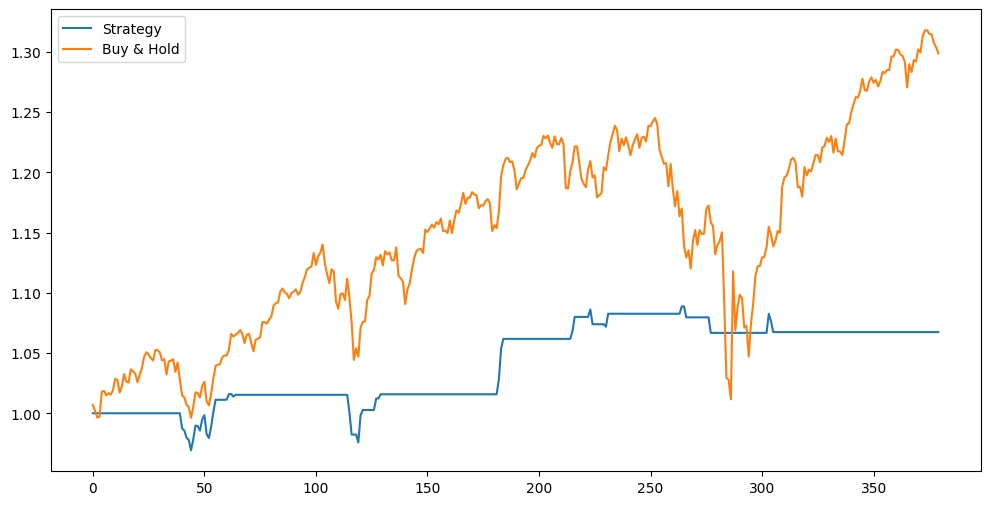

In [205]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 5.3.a — predict helper
def predict_lstm(model, X_s, batch_size=256, device=None):
    """
    Run model on a 3D tensor (N, L, F) and return 1D predictions.
    """
    # STEP 1: set device and model.eval()
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()
    preds = []
    # STEP 2: loop over X_s in batches, collect preds
    with torch.no_grad():
        for i in range(0, len(X_s), batch_size):
            xb = torch.tensor(X_s[i:i+batch_size], dtype=torch.float32).to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
    # STEP 3: return preds as 1D np.array
    return np.concatenate(preds)

# 5.3.b — metrics
def mae(y_true, y_pred):
    # STEP: return mean absolute error
    return np.mean(np.abs(y_true - y_pred))

def directional_accuracy(y_true, y_pred):
    # STEP: fraction of matching signs
    return np.mean(np.sign(y_true) == np.sign(y_pred))


# 5.3.c — simple long/flat strategy
def long_flat_returns(y_pred, y_true, thresh=0.0):
    """
    long if predicted > thresh, else flat.
    returns daily strategy returns.
    """
    # STEP: signal = (y_pred > thresh).astype(int)
    signal = (y_pred > thresh).astype(int)
    # STEP: return signal * y_true
    return signal * y_true


def cumulative_curve(returns):
    # STEP: return (1 + returns).cumprod()
    return (1 + returns).cumprod()

# 5.3.d — run evaluation
# 1) preds on val + test
yva_pred = predict_lstm(model, X_va_s)
yte_pred = predict_lstm(model, X_te_s)
# 2) print MAE and DA for both
print("Validation MAE:", mae(y_va, yva_pred))
print("Validation DA:", directional_accuracy(y_va, yva_pred))
print("Test MAE:", mae(y_te, yte_pred))
print("Test DA:", directional_accuracy(y_te, yte_pred))
# 3) plot cumulative curves for test: strategy vs buy&hold
plt.figure(figsize=(12, 6))
plt.plot(cumulative_curve(long_flat_returns(yte_pred, y_te)), label="Strategy")
plt.plot(cumulative_curve(y_te), label="Buy & Hold")
plt.legend()
plt.show()

# Chapter 6 - Feature Engineering

In [206]:
import numpy as np
import pandas as pd

def add_trend_features(df, close_col=close_var):
    """
    Adds:
      - lagged returns: r_1, r_2, r_5
      - rolling mean/std of returns: ret_mean_{5,10,20}, ret_std_{5,10,20}
      - price z-score over windows: zprice_{20,50}
      - Bollinger %b over window=20, k=2: bbp_20
    Returns a new DataFrame (do not dropna here; caller can drop).
    """
    df = df.copy()
    price = df[close_col]

    # --- returns ---
    df["ret_1d"] = price.pct_change()
    # STEP: lagged returns r_1, r_2, r_5 based on ret_1d (use .shift(k))
    df["r_1"] = df["ret_1d"].shift(1)
    df["r_2"] = df["ret_1d"].shift(2)
    df["r_5"] = df["ret_1d"].shift(5)

    # --- rolling stats on returns ---
    for w in (5, 10, 20):
        # STEP: rolling mean of ret_1d over window w -> df[f"ret_mean_{w}"]
        df[f"ret_mean_{w}"] = df["ret_1d"].rolling(w).mean()
        # STEP: rolling std  of ret_1d over window w -> df[f"ret_std_{w}"]
        df[f"ret_std_{w}"] = df["ret_1d"].rolling(w).std()

    # --- price z-scores ---
    for w in (20, 50):
        mu = price.rolling(w).mean()
        sd = price.rolling(w).std()
        # STEP: z-score -> (price - mu) / (sd + 1e-8), name df[f"zprice_{w}"]
        df[f"zprice_{w}"] = (price - mu) / (sd + 1e-8)

    # --- Bollinger %b (w=20, k=2) ---
    w, k = 20, 2
    mu20 = price.rolling(w).mean()
    sd20 = price.rolling(w).std()
    lower = mu20 - k * sd20
    upper = mu20 + k * sd20
    # STEP: %b = (price - lower) / (upper - lower + 1e-8) -> df["bbp_20"]
    df["bbp_20"] = (price - lower) / (upper - lower + 1e-8)

    return df

In [207]:
df_fe = add_trend_features(df)  # start from your df with OHLCV
# keep your existing RSI/SMA/momentum if you like, or add after this call
# re-make targets:
df_fe["target_reg"] = df_fe["ret_1d"].shift(-1)
df_fe["target_cls"] = (df_fe["target_reg"] > 0).astype(int)
df_fe = df_fe.dropna()

In [208]:
new_cols = [c for c in df_fe.columns if c not in ["close_spy","open_spy","high_spy","low_spy","volume_spy"]]
df_fe[new_cols].head()

,ret_1d,sma_50,sma_5,mom_5,vol_5,sma_10,mom_10,vol_10,sma_20,mom_20,...,r_5,ret_mean_5,ret_std_5,ret_mean_10,ret_std_10,ret_mean_20,ret_std_20,zprice_20,zprice_50,bbp_20
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-26,-0.010752,175.832444,178.365533,-0.011263,0.005124,177.916721,0.000427,0.005364,177.065247,-0.000332,...,0.003107,-0.002252,0.005124,0.000056,0.005364,0.000005,0.006775,-0.221418,0.519117,0.444645
2015-05-27,0.009492,175.917122,178.310172,-0.001549,0.007416,178.144902,0.012954,0.005992,177.118098,0.005959,...,-0.000329,-0.000288,0.007416,0.001304,0.005992,0.000321,0.007072,0.916841,1.398950,0.729210
2015-05-28,-0.001129,176.008127,178.239694,-0.001973,0.007424,178.349591,0.011618,0.006033,177.197373,0.008976,...,-0.000704,-0.000373,0.007424,0.001172,0.006033,0.000470,0.007004,0.713024,1.236583,0.678256
2015-05-29,-0.006213,176.035227,177.843729,-0.011054,0.007535,178.259828,-0.005042,0.005465,177.309784,0.012856,...,0.002912,-0.002198,0.007535,-0.000492,0.005465,0.000661,0.006751,-0.138298,0.603378,0.465425
2015-06-01,0.002037,176.085577,177.605481,-0.006667,0.007764,178.186845,-0.004095,0.005504,177.345438,0.004034,...,-0.002389,-0.001313,0.007764,-0.000397,0.005504,0.000220,0.006326,0.104047,0.773388,0.526012


In [209]:
import pandas as pd
import numpy as np

# assume: df has columns like close_spy, open_spy, high_spy, low_spy, volume_spy
# and you defined: close_var = "close_spy"

def build_feature_df(df, close_var="close_spy"):
    df = df.copy()

    # 1) Keep raw OHLCV as-is
    raw_cols = ["open_spy","high_spy","low_spy","close_spy","volume_spy"]
    assert all(c in df.columns for c in raw_cols), "Missing OHLCV cols"

    # 2) Add engineered trend features
    df_fe = add_trend_features(df, close_col=close_var)

    # 3) (Optional) keep your earlier SMA/momentum if you want:
    #    If you already have sma_5, sma_50, mom_5, vol_5 in df, they’ll carry through.
    #    Otherwise you can compute them here similarly.

    # 4) Targets (based on ret_1d we created in add_trend_features)
    df_fe["target_reg"] = df_fe["ret_1d"].shift(-1)
    df_fe["target_cls"] = (df_fe["target_reg"] > 0).astype(int)

    # 5) Drop NaNs from rolling/lagged/shifted features
    df_fe = df_fe.dropna().copy()

    return df_fe

df_all = build_feature_df(df, close_var=close_var)
df_all.head()

,close_spy,high_spy,low_spy,open_spy,volume_spy,ret_1d,sma_50,sma_5,mom_5,vol_5,...,r_5,ret_mean_5,ret_std_5,ret_mean_10,ret_std_10,ret_mean_20,ret_std_20,zprice_20,zprice_50,bbp_20
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-26,176.754837,178.608797,176.335390,178.180953,124308600,-0.010752,175.832444,178.365533,-0.011263,0.005124,...,0.003107,-0.002252,0.005124,0.000056,0.005364,0.000005,0.006775,-0.221418,0.519117,0.444645
2015-05-27,178.432663,178.667552,176.805207,177.216270,93214000,0.009492,175.917122,178.310172,-0.001549,0.007416,...,-0.000329,-0.000288,0.007416,0.001304,0.005992,0.000321,0.007072,0.916841,1.398950,0.729210
2015-05-28,178.231293,178.340340,177.535010,178.122232,74974600,-0.001129,176.008127,178.239694,-0.001973,0.007424,...,-0.000704,-0.000373,0.007424,0.001172,0.006033,0.000470,0.007004,0.713024,1.236583,0.678256
2015-05-29,177.123932,178.206099,176.855493,178.164164,124919600,-0.006213,176.035227,177.843729,-0.011054,0.007535,...,0.002912,-0.002198,0.007535,-0.000492,0.005465,0.000661,0.006751,-0.138298,0.603378,0.465425
2015-06-01,177.484680,178.130619,176.687721,177.795067,93338800,0.002037,176.085577,177.605481,-0.006667,0.007764,...,-0.002389,-0.001313,0.007764,-0.000397,0.005504,0.000220,0.006326,0.104047,0.773388,0.526012


In [210]:
# time split (same dates as before)
TRAIN_END = pd.Timestamp("2021-12-31")
VAL_END   = pd.Timestamp("2023-12-31")

train_df = df_all.loc[:TRAIN_END].copy()
val_df   = df_all.loc[TRAIN_END + pd.Timedelta(days=1) : VAL_END].copy()
test_df  = df_all.loc[VAL_END + pd.Timedelta(days=1) : ].copy()

# features = everything except targets
feature_cols = [c for c in df_all.columns if c not in ("target_reg","target_cls")]

# windowing
lookback = 30
X_tr, y_tr = make_xy(train_df, feature_cols, "target_reg", lookback)
X_va, y_va = make_xy(val_df,   feature_cols, "target_reg", lookback)
X_te, y_te = make_xy(test_df,  feature_cols, "target_reg", lookback)

# scaling (fit on train only)
X_tr_s, X_va_s, X_te_s, scaler = scale_3d(X_tr, X_va, X_te)

# quick checks
print("Shapes:", X_tr_s.shape, X_va_s.shape, X_te_s.shape)
print("Num features:", X_tr_s.shape[-1])
print("Any NaN?", np.isnan(X_tr_s).any(), np.isnan(y_tr).any())

Shapes: (1635, 30, 29) (471, 30, 29) (379, 30, 29)
Num features: 29
Any NaN? False False


In [211]:
# 6.3 — Re-test Ridge regression with engineered features

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# a) flatten windows (reuse from before or reimplement)
def flatten_windows(X):
    """
    X: (N, L, F) -> (N, L*F)
    """
    # STEP: get shape and reshape to 2D
    n, L, f = X.shape
    return X.reshape(n, L * f)

# b) train ridge on TRAIN only
def train_ridge_reg(X_tr_s, y_tr, alpha=1.0):
    """
    Fit Ridge regression on flattened train windows.
    """
    # STEP: flatten train windows
    Xtr = flatten_windows(X_tr_s)
    # STEP: init model (alpha, fit_intercept=True, random_state=0)
    model = Ridge(alpha=alpha, fit_intercept=True, random_state=0)
    # STEP: fit and return
    model.fit(Xtr, y_tr)
    return model

# c) evaluate (MAE, Directional Accuracy)
def eval_linreg(model, X_s, y_true):
    """
    Predict for a split and compute metrics.
    Returns y_pred, MAE, DA
    """
    # STEP: flatten X_s
    Xflat = flatten_windows(X_s)
    # STEP: predict
    y_pred = model.predict(Xflat)
    # STEP: MAE and DA
    mae = mean_absolute_error(y_true, y_pred)
    da  = (np.sign(y_true) == np.sign(y_pred)).mean()
    return y_pred, mae, da

# d) run it (try a couple of alphas)
alphas = [0.1, 1.0, 10.0]
results = []
for a in alphas:
    model = train_ridge_reg(X_tr_s, y_tr, alpha=a)
    yva_pred, va_mae, va_da = eval_linreg(model, X_va_s, y_va)
    yte_pred, te_mae, te_da = eval_linreg(model, X_te_s, y_te)
    results.append((a, va_mae, va_da, te_mae, te_da))
    print(f"alpha={a:<4} | VAL MAE {va_mae:.6f} DA {va_da:.3f} | TEST MAE {te_mae:.6f} DA {te_da:.3f}")


alpha=0.1  | VAL MAE 0.010551 DA 0.550 | TEST MAE 0.010465 DA 0.496
alpha=1.0  | VAL MAE 0.009929 DA 0.546 | TEST MAE 0.008813 DA 0.507
alpha=10.0 | VAL MAE 0.009868 DA 0.544 | TEST MAE 0.008221 DA 0.520


Epoch 01 | val_L1=0.103334
Epoch 02 | val_L1=0.040450
Epoch 03 | val_L1=0.052556
Epoch 04 | val_L1=0.047390
Epoch 05 | val_L1=0.038020
Epoch 06 | val_L1=0.031112
Epoch 07 | val_L1=0.032675
Epoch 08 | val_L1=0.027013
Epoch 09 | val_L1=0.020714
Epoch 10 | val_L1=0.018622
Epoch 11 | val_L1=0.017499
Epoch 12 | val_L1=0.019888
Epoch 13 | val_L1=0.016475
Epoch 14 | val_L1=0.016002
Epoch 15 | val_L1=0.017326
Epoch 16 | val_L1=0.015706
Epoch 17 | val_L1=0.014378
Epoch 18 | val_L1=0.013749
Epoch 19 | val_L1=0.013190
Epoch 20 | val_L1=0.014276
Epoch 21 | val_L1=0.013362
Epoch 22 | val_L1=0.013069
Epoch 23 | val_L1=0.013071
Epoch 24 | val_L1=0.013114
Epoch 25 | val_L1=0.013951
Epoch 26 | val_L1=0.014737
Epoch 27 | val_L1=0.012321
Epoch 28 | val_L1=0.012364
Epoch 29 | val_L1=0.012489
Epoch 30 | val_L1=0.011869
Epoch 31 | val_L1=0.013052
Epoch 32 | val_L1=0.012405
Epoch 33 | val_L1=0.011809
Epoch 34 | val_L1=0.011787
Epoch 35 | val_L1=0.011747
Epoch 36 | val_L1=0.011826
Epoch 37 | val_L1=0.011511
E

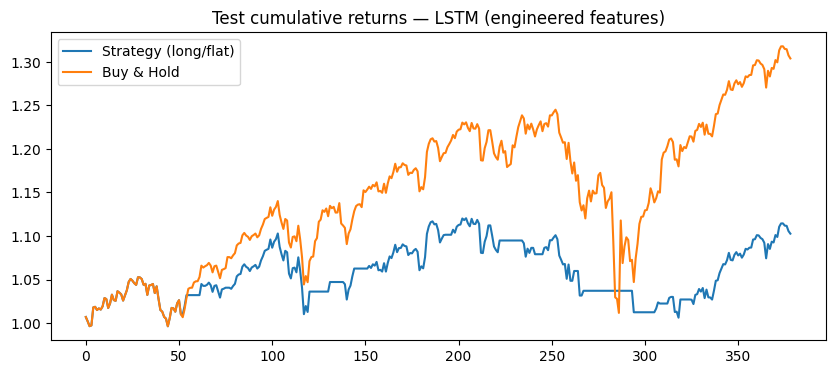

In [212]:
# (re)train LSTM on X_tr_s / y_tr, validate on X_va_s / y_va

import torch, numpy as np

n_features = X_tr_s.shape[-1]
torch.manual_seed(42); np.random.seed(42)

model = LSTMRegressor(
    n_features=n_features,
    hidden_size=64,
    num_layers=1,
    dropout=0.2,
)

model, best_val = train_model_stable(
    model,
    X_tr_s, y_tr,
    X_va_s, y_va,
    lr=1e-4,
    batch_size=64,
    max_epochs=40,
    patience=6,
)

print("Best val L1:", best_val)

# --- Evaluate on VAL + TEST ---
yva_pred = predict_lstm(model, X_va_s)
yte_pred = predict_lstm(model, X_te_s)

val_mae = mae(y_va, yva_pred);  val_da = directional_accuracy(y_va, yva_pred)
test_mae = mae(y_te, yte_pred); test_da = directional_accuracy(y_te, yte_pred)

print(f"VAL  | MAE {val_mae:.6f} | DA {val_da:.3f}")
print(f"TEST | MAE {test_mae:.6f} | DA {test_da:.3f}")

# --- Simple strategy curve on TEST ---
eq_strat = cumulative_curve(long_flat_returns(yte_pred, y_te, thresh=0.0))
eq_bh    = cumulative_curve(y_te)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(eq_strat, label="Strategy (long/flat)")
plt.plot(eq_bh, label="Buy & Hold")
plt.legend(); plt.title("Test cumulative returns — LSTM (engineered features)"); plt.show()

# Chapter 7 - The Switch

In [213]:
def prep_for_xgb(X_tr_s, X_va_s, X_te_s):
    """
    Flatten 3D windows into 2D for XGBoost.
    Input: (n, L, f)
    Output: (n, L*f)
    """
    # STEP 1: get shape info
    n, L, f = X_tr_s.shape
    n_va = X_va_s.shape[0]
    n_te = X_te_s.shape[0]
    # STEP 2: reshape train, val, test into (n, L*f)
    X_tr_flat = X_tr_s.reshape(n, L*f)
    X_va_flat = X_va_s.reshape(n_va, L*f)
    X_te_flat = X_te_s.reshape(n_te, L*f)
    # STEP 3: return them
    return X_tr_flat, X_va_flat, X_te_flat

In [214]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np

def train_xgb_tuned(X_tr, y_tr, X_va, y_va):
    model = xgb.XGBRegressor(
        n_estimators=500,       # more trees
        learning_rate=0.05,     # smaller step size (slower, but steadier)
        max_depth=6,            # let splits go deeper (more complexity)
        subsample=0.8,          # use 80% of rows per tree (prevents overfitting)
        colsample_bytree=0.8,   # use 80% of features per tree
        random_state=0
    )
    model.fit(X_tr, y_tr)
    
    y_pred_va = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred_va)
    da = (np.sign(y_va) == np.sign(y_pred_va)).mean()
    return model, mae, da

In [215]:
X_tr_flat, X_va_flat, X_te_flat = prep_for_xgb(X_tr_s, X_va_s, X_te_s)
model, va_mae, va_da = train_xgb_tuned(X_tr_flat, y_tr, X_va_flat, y_va)
print("VAL | MAE:", round(va_mae, 6), "| DA:", round(va_da, 3))

VAL | MAE: 0.00957 | DA: 0.493


In [216]:
# predict on test
y_te_pred = model.predict(X_te_flat)

# metrics
def mae(y_true, y_pred): 
    import numpy as np
    return np.mean(np.abs(y_true - y_pred))

def directional_accuracy(y_true, y_pred):
    import numpy as np
    return (np.sign(y_true) == np.sign(y_pred)).mean()

te_mae = mae(y_te, y_te_pred)
te_da  = directional_accuracy(y_te, y_te_pred)
print(f"TEST | MAE: {te_mae:.6f} | DA: {te_da:.3f}")

TEST | MAE: 0.007351 | DA: 0.557


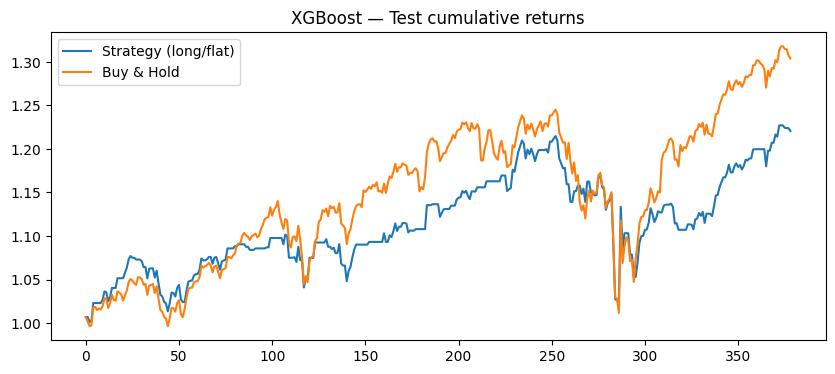

In [217]:
import numpy as np, matplotlib.pyplot as plt

def long_flat_returns(y_pred, y_true, thresh=0.0):
    signal = (y_pred > thresh).astype(int)
    return signal * y_true

def cumulative_curve(returns):
    return (1 + returns).cumprod()

eq_strat = cumulative_curve(long_flat_returns(y_te_pred, y_te))
eq_bh    = cumulative_curve(y_te)

plt.figure(figsize=(10,4))
plt.plot(eq_strat, label="Strategy (long/flat)")
plt.plot(eq_bh,    label="Buy & Hold")
plt.title("XGBoost — Test cumulative returns")
plt.legend(); plt.show()

In [218]:
# evaluate tuned model on test
y_pred_te = model.predict(X_te_flat)
test_mae = mean_absolute_error(y_te, y_pred_te)
test_da  = (np.sign(y_te) == np.sign(y_pred_te)).mean()

print("TEST | MAE:", round(test_mae, 6), "| DA:", round(test_da, 3))

TEST | MAE: 0.007351 | DA: 0.557


# Chapter 8 - Further Strategies